In [1]:
!pip install "unsloth[colab-new]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.8/544.8 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.7/131.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 21.3 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [1]:
from unsloth import FastLanguageModel
import transformers

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
import json
from sklearn.model_selection import train_test_split

# Path to your prepared JSONL
jsonl_path = "/content/sample_data/final_row_prompt.jsonl"
# Read all lines
with open(jsonl_path, 'r') as f:
    lines = f.readlines()

# Split
train_lines, val_lines = train_test_split(lines, test_size=0.2, random_state=42)

# Save splits
with open("train_100.jsonl", 'w') as f:
    f.writelines(train_lines)

with open("val_100.jsonl", 'w') as f:
    f.writelines(val_lines)

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "marcelbinz/Llama-3.1-Minitaur-8B"   # update if your exact HF id differs


# 4-bit quantization config (QLoRA defaults)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,  # A100 supports bfloat16
    llm_int8_enable_fp32_cpu_offload=True # Enable CPU offloading for 32-bit modules
)

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Define a custom device map to handle potential offloading
device_map = {"": 0} # Try to put most layers on GPU 0

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map, # Use the custom device map
    trust_remote_code=True,  # in case the repo defines custom modeling
)
model.config.use_cache = False  # important with gradient checkpointing

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# Prepare the quantized model for k-bit training
model = prepare_model_for_kbit_training(model)

# A solid LoRA config for small instruction-style datasets (~4k samples)
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 41,943,040 || all params: 8,072,204,288 || trainable%: 0.5196


In [5]:
from datasets import load_dataset

data_files = {"train": "train_100.jsonl", "validation": "val_100.jsonl"}
raw_ds = load_dataset("json", data_files=data_files)

# Quick peek
print(raw_ds)
print(raw_ds["train"][0])

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Age', 'Gender', 'PTSD_Level', 'PreviousDiagnosis_List', 'PreviousDiagnosis_Other', 'event_description', 'event_rating', 'participantid_num'],
        num_rows: 22000
    })
    validation: Dataset({
        features: ['Age', 'Gender', 'PTSD_Level', 'PreviousDiagnosis_List', 'PreviousDiagnosis_Other', 'event_description', 'event_rating', 'participantid_num'],
        num_rows: 5500
    })
})
{'Age': 49, 'Gender': 'Female', 'PTSD_Level': 'High PTSD', 'PreviousDiagnosis_List': 'Posttraumatic Stress Disorder', 'PreviousDiagnosis_Other': None, 'event_description': 'lost a family member in an earthquake', 'event_rating': 5.0, 'participantid_num': 78}


In [6]:
# Make sure tokenizer can pad
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

# For inference later: caching ON, checkpointing OFF
model.eval()
if getattr(model, "gradient_checkpointing", False):
    try:
        model.gradient_checkpointing_disable()
    except Exception:
        pass
model.config.use_cache = True

In [7]:
EOS = tokenizer.eos_token or ""
tokenizer.padding_side = "right"
MAX_LEN = 256  # 128 if you want faster training

def build_example(prompt: str, completion: str):
    prompt_text = prompt.strip() + "\n\nAnswer:"
    completion_text = " " + str(completion).strip() + EOS
    p = tokenizer(prompt_text, add_special_tokens=False).input_ids
    c = tokenizer(completion_text, add_special_tokens=False).input_ids
    input_ids = p + c
    labels = [-100]*len(p) + c
    attn = [1]*len(input_ids)

    if len(input_ids) > MAX_LEN:
        input_ids = input_ids[-MAX_LEN:]
        labels    = labels[-MAX_LEN:]
        attn      = attn[-MAX_LEN:]

    pad = MAX_LEN - len(input_ids)
    if pad > 0:
        input_ids += [tokenizer.pad_token_id]*pad
        labels    += [-100]*pad
        attn      += [0]*pad

    return {"input_ids": input_ids, "attention_mask": attn, "labels": labels}

def preprocess(batch):
    out = {"input_ids": [], "attention_mask": [], "labels": []}
    for d, r, lvl in zip(batch["event_description"], batch["event_rating"], batch["PTSD_Level"]):
        completion = f"{float(r):.1f} with {lvl} PTSD"
        ex = build_example(d, completion)
        for k in out: out[k].append(ex[k])
    return out

tokenized_ds = raw_ds.map(preprocess, batched=True,
                          remove_columns=raw_ds["train"].column_names).with_format("torch")


Map:   0%|          | 0/22000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [8]:
if "validation" not in tokenized_ds:
    split = tokenized_ds["train"].train_test_split(test_size=0.1, seed=42)
    tokenized_ds = {"train": split["train"], "validation": split["test"]}


In [9]:
import torch

# Detect capabilities
has_cuda = torch.cuda.is_available()
cap = torch.cuda.get_device_capability(0) if has_cuda else (0, 0)
is_ampere_plus = has_cuda and cap[0] >= 8  # Ampere (8.x) or newer supports bf16

# Precision flags for Trainer
use_bf16 = is_ampere_plus            # True on A100/Ampere+; False on T4/V100/CPU
use_fp16 = has_cuda and not use_bf16 # True on pre-Ampere CUDA GPUs; False on CPU

print(f"CUDA: {has_cuda}, capability: {cap}, bf16: {use_bf16}, fp16: {use_fp16}")


CUDA: True, capability: (8, 9), bf16: True, fp16: False


In [11]:
# in Colab / Jupyter cell
!pip install -U "transformers>=4.40" accelerate datasets peft
import transformers, torch
print("Transformers:", transformers.__version__)
print("Torch:", torch.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 107.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.4
    Uninstalling tokenizers-0.21.4:
      Successfully uninstalled tokenizers-0.21.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.4
    Uninstalling transformers-4.55.4:
      Successfully uninstalled transformers-4.55.4
  Attempting uninstall: datasets
    Found existing installation: datasets 3.6.0
    Uninstalling datasets-3.6.0:
      Successfully uninstalled datasets-3.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflic

Transformers: 4.55.4
Torch: 2.8.0+cu126


In [10]:
from transformers import TrainingArguments

MAX_STEPS = 900
EVAL_STEPS = 150   # we'll handle this via a callback
SAVE_STEPS = 150

args = TrainingArguments(
    output_dir="minitaur-stroop-qlora",
    num_train_epochs=100,          # ignored because max_steps > 0
    max_steps=MAX_STEPS,

    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    gradient_accumulation_steps=1,

    learning_rate=2e-4,
    logging_steps=50,

    save_steps=SAVE_STEPS,         # fine to keep; older versions support this
    save_total_limit=2,

    fp16=use_fp16,                 # keep if your env supports it
    remove_unused_columns=False,
)


In [13]:
from transformers import Trainer, TrainerCallback, default_data_collator

class EvalEveryNSteps(TrainerCallback):
    def __init__(self, eval_steps=150, save_steps=None):
        self.eval_steps = int(eval_steps)
        self.save_steps = int(save_steps) if save_steps is not None else int(eval_steps)

    def on_step_end(self, args, state, control, **kwargs):
        # Trigger evaluation
        if state.global_step > 0 and state.global_step % self.eval_steps == 0:
            control.should_evaluate = True
        # Trigger checkpoint save
        if state.global_step > 0 and state.global_step % self.save_steps == 0:
            control.should_save = True
        return control

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    data_collator=default_data_collator,
    callbacks=[EvalEveryNSteps(eval_steps=EVAL_STEPS, save_steps=SAVE_STEPS)],
)
trainer.train()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arshadjafrisheikh (arshadjafrisheikh-ut-arlington-uta-the-university-of-tex) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


TrainOutput(global_step=900, training_loss=0.17281278080410428, metrics={'train_runtime': 14030.1868, 'train_samples_per_second': 0.77, 'train_steps_per_second': 0.064, 'total_flos': 1.251934791008256e+17, 'train_loss': 0.17281278080410428, 'epoch': 0.49073064340239914})

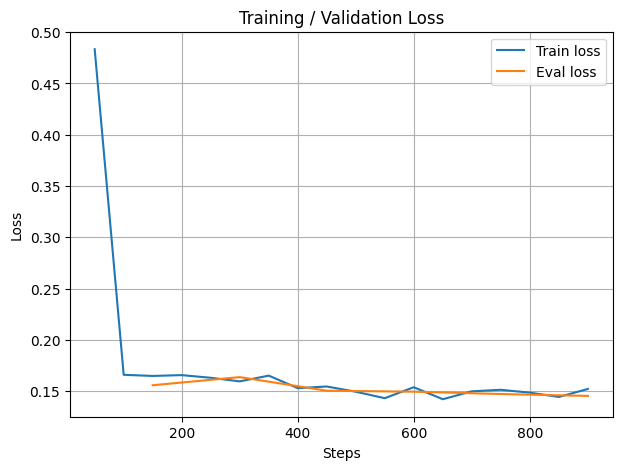

In [14]:
import matplotlib.pyplot as plt

hist = trainer.state.log_history
steps = [h["step"] for h in hist if "loss" in h]
train_loss = [h["loss"] for h in hist if "loss" in h]
eval_steps = [h["step"] for h in hist if "eval_loss" in h]
eval_loss = [h["eval_loss"] for h in hist if "eval_loss" in h]

plt.figure(figsize=(7,5))
plt.plot(steps, train_loss, label="Train loss")
if len(eval_loss) > 0:
    plt.plot(eval_steps, eval_loss, label="Eval loss")
plt.xlabel("Steps"); plt.ylabel("Loss")
plt.title("Training / Validation Loss")
plt.grid(True); plt.legend(); plt.show()


In [30]:
# After training finishes
hist = trainer.state.log_history

# Collect all evaluation logs
eval_losses = [(h["step"], h["eval_loss"]) for h in hist if "eval_loss" in h]
print(eval_losses[:10])   # first 10 eval points


[(150, 0.15583229064941406), (300, 0.1637447476387024), (450, 0.1505081057548523), (600, 0.14954763650894165), (750, 0.14725911617279053), (900, 0.14543280005455017)]


In [31]:
import math

for step, loss in eval_losses:
    ppl = math.exp(loss)
    print(f"Step {step} | Eval loss {loss:.4f} | Perplexity {ppl:.2f}")


Step 150 | Eval loss 0.1558 | Perplexity 1.17
Step 300 | Eval loss 0.1637 | Perplexity 1.18
Step 450 | Eval loss 0.1505 | Perplexity 1.16
Step 600 | Eval loss 0.1495 | Perplexity 1.16
Step 750 | Eval loss 0.1473 | Perplexity 1.16
Step 900 | Eval loss 0.1454 | Perplexity 1.16


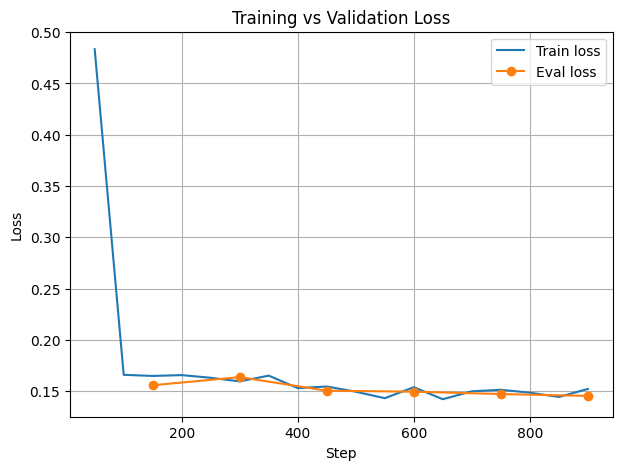

In [32]:
import matplotlib.pyplot as plt

steps = [h["step"] for h in hist if "loss" in h]
train_loss = [h["loss"] for h in hist if "loss" in h]
eval_steps = [h["step"] for h in hist if "eval_loss" in h]
eval_loss = [h["eval_loss"] for h in hist if "eval_loss" in h]

plt.figure(figsize=(7,5))
plt.plot(steps, train_loss, label="Train loss")
plt.plot(eval_steps, eval_loss, label="Eval loss", marker="o")
plt.xlabel("Step"); plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(); plt.grid(True); plt.show()


In [15]:
model.eval()
if getattr(model, "gradient_checkpointing", False):
    try: model.gradient_checkpointing_disable()
    except Exception: pass
model.config.use_cache = True

if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token


In [16]:
def generate_eval(desc: str, max_new_tokens=12, sample=False):
    text = desc.strip() + "\n\nAnswer:"
    inputs = tokenizer(text, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.inference_mode():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=sample,
            temperature=0.7 if sample else None,
            top_p=0.9 if sample else None,
            top_k=50 if sample else None,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            no_repeat_ngram_size=3,
            repetition_penalty=1.15,
        )
    gen = out[0][inputs["input_ids"].shape[1]:]
    return tokenizer.decode(gen, skip_special_tokens=True).strip()


In [18]:
output_dir = "/content/drive/MyDrive/minitaur_model_checkpoint"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
# trainer.save_model(output_dir)  # optional; includes optimizer states

# Reload later (eval-only or inference):
from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(output_dir, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(output_dir, torch_dtype=torch.float16)
model.eval()
model.config.use_cache = True

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [19]:
import torch

# One-time hygiene (do this once in your session after loading the model)
model.eval()
if getattr(model, "gradient_checkpointing", False):
    try: model.gradient_checkpointing_disable()
    except Exception: pass
model.config.use_cache = True
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

def generate_eval(desc: str, max_new_tokens=12, sample=False):
    """Generates a single-line answer like: '3.0 with Moderate PTSD'."""
    prompt = desc.strip() + "\n\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.inference_mode():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=sample,                      # False = deterministic, True = sampled
            temperature=0.7 if sample else None,
            top_p=0.9 if sample else None,
            top_k=50 if sample else None,
            eos_token_id=tokenizer.eos_token_id,   # stop at EOS
            pad_token_id=tokenizer.pad_token_id,
            no_repeat_ngram_size=3,
            repetition_penalty=1.15,
        )

    gen_ids = out[0][inputs["input_ids"].shape[1]:]
    text_out = tokenizer.decode(gen_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return text_out.splitlines()[0].strip()  # keep only first line after "Answer:"


In [26]:
desc = "The participant reported recurring nightmares and difficulty sleeping after the accident."
print(generate_eval(desc))            # deterministic
print(generate_eval(desc, sample=True))  # sampled variant


5.0 with High PTSD PTSD
4.0 with Medium PTSD PTSD


In [27]:
import torch

# Few-shot template (edit examples as you like)
FEWSHOT_TEMPLATE = """You are given short event descriptions.
Respond with "<rating> with <PTSD_Level> PTSD".

Example:
The subject avoids driving and experiences flashbacks when hearing sirens.

Answer: 4.0 with Severe PTSD

Example:
Sleep is mostly normal, occasional anxious thoughts after work.

Answer: 1.5 with Mild PTSD

Now answer this:

{desc}

Answer:"""

# One-time hygiene (after loading model/tokenizer)
model.eval()
if getattr(model, "gradient_checkpointing", False):
    try: model.gradient_checkpointing_disable()
    except Exception: pass
model.config.use_cache = True
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

def generate_fewshot(desc: str,
                     max_new_tokens: int = 16,
                     sample: bool = False) -> str:
    # 1) Build prompt
    prompt = FEWSHOT_TEMPLATE.format(desc=desc.strip())

    # 2) Ensure the prompt doesn’t eat the whole context
    # Reserve headroom for generation by truncating the *input* if needed
    # (Set this to your model’s max length; 2048/4096/etc. Use smaller if VRAM is tight.)
    INPUT_MAX = 1024
    enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=INPUT_MAX)
    enc = {k: v.to(model.device) for k, v in enc.items()}

    # 3) First attempt (deterministic)
    with torch.inference_mode():
        out = model.generate(
            **enc,
            max_new_tokens=max_new_tokens,
            min_new_tokens=1,                 # ← ensure at least 1 token
            do_sample=sample,
            temperature=0.7 if sample else None,
            top_p=0.9 if sample else None,
            top_k=50 if sample else None,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            no_repeat_ngram_size=3,
            repetition_penalty=1.15,
            early_stopping=True,
        )

    gen_ids = out[0][enc["input_ids"].shape[1]:]
    text_out = tokenizer.decode(gen_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True).strip()

    # 4) If empty, retry once with a more permissive decode
    if not text_out:
        with torch.inference_mode():
            out = model.generate(
                **enc,
                max_new_tokens=max_new_tokens * 2,  # give more room
                min_new_tokens=1,
                do_sample=False,                     # deterministic, stable
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.pad_token_id,
                early_stopping=True,
            )
        gen_ids = out[0][enc["input_ids"].shape[1]:]
        text_out = tokenizer.decode(gen_ids, skip_special_tokens=True).strip()

    # 5) Last guard: return a placeholder instead of crashing
    if not text_out:
        return "[no output]"

    # Keep only first line to avoid multi-line “splitting”
    return text_out.splitlines()[0].strip()


In [28]:
desc = "The participant reported recurring nightmares and difficulty sleeping after the accident."
print(generate_fewshot(desc))            # deterministic
print(generate_fewshot(desc, sample=True))  # with sampling for variety


7.0 PTSD PTSD
**7.0** with High PTSD PTSD


In [29]:
from tqdm import tqdm
import torch

def label_text(ex):
    y_ids = [t for t in ex["labels"] if t != -100]
    return tokenizer.decode(y_ids, skip_special_tokens=True).strip()

def predict_text(desc):
    return generate_fewshot(desc, max_new_tokens=12, sample=False)

# Collect true and predicted labels
y_true, y_pred = [], []

for ex in tqdm(tokenized_ds["validation"]):
    # Recover description text (everything before "Answer:")
    prompt_ids = [i for i, m in zip(ex["input_ids"], ex["attention_mask"]) if m == 1]
    prompt_text = tokenizer.decode(prompt_ids, skip_special_tokens=True)
    desc = prompt_text.split("\n\nAnswer:", 1)[0]

    pred = predict_text(desc)
    true = label_text(ex)

    y_true.append(true)
    y_pred.append(pred)


  0%|          | 1/5500 [00:35<53:55:29, 35.30s/it]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

labels = sorted(set(y_true))  # unique target labels
cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=[f"True:{l}" for l in labels], columns=[f"Pred:{l}" for l in labels])
print(cm_df)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of PTSD Predictions")
plt.show()

accuracy = sum(yt == yp for yt, yp in zip(y_true, y_pred)) / len(y_true)
print(f"Exact match accuracy: {accuracy:.2%}")
